In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm

import numpy as np

from collections import Counter, defaultdict

In [2]:
dat = sorted(glob('Data/*')) 

start_index = dat.index('Data/IMG_1011.mp4')

train_dat = dat[start_index+1:]
test_dat = dat[:start_index+1]
len(dat)

127

In [3]:
def preproc(image):
    image = image.reshape(720, 1280, 3)[:, 100:-100, :]
    
    final_wide = 200
    r = float(final_wide) / image.shape[1]
    dim = (final_wide, int(image.shape[0] * r))

    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    return resized

In [4]:
def generate_dset(pathes, description='description.txt'):
    dset = []
    dct = {}
    with open(description, 'r') as f:
        for line in f:
            key, val = line.split()
            dct[key] = val
    for f_name in tqdm(pathes):
        cur_set = []
        vidcap = cv2.VideoCapture(f_name)
        success, image = vidcap.read()
        while success:
            image = preproc(image)
            cur_set.append(image)
            success, image = vidcap.read()
        key = f_name[f_name.rfind('/')+1:]
        cur_set = np.stack(cur_set)
        cur_set = torch.from_numpy(cur_set).float()
        dset.append(((cur_set), dct[key]))
    return dset

In [5]:
train_set = generate_dset(train_dat)

100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


In [6]:
test_set = generate_dset(test_dat)

100%|██████████| 27/27 [00:04<00:00,  6.12it/s]


In [7]:
labels = list(set([x[1] for x in train_set]))
test_set = [x for x in test_set if x[1] in labels]

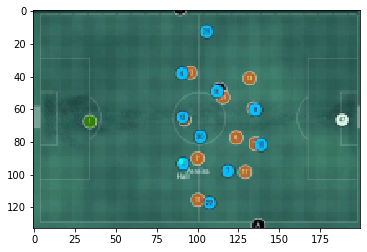

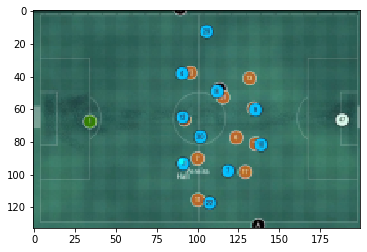

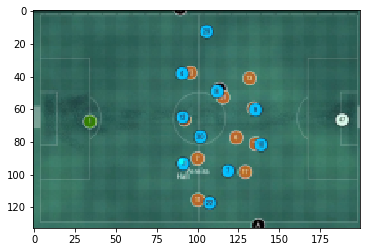

In [8]:
for image in train_set[0][0][::9]:
    plt.imshow(image.int())
    plt.show()

In [9]:
c2ix = {t: i for i, t in enumerate(list(set([x[1] for x in train_set])))}
ix2c = {val: key for key, val in c2ix.items()}

In [10]:
c = Counter(list([x[1] for x in train_set]))

In [11]:
c.most_common()

[('pos_attac', 26),
 ('build_up', 16),
 ('mid_press', 13),
 ('stand_attac', 11),
 ('pos_defence', 9),
 ('corn_defence', 9),
 ('high_press', 6),
 ('stand_defence', 4),
 ('counter', 3),
 ('clear', 1),
 ('corn_defense', 1),
 ('pos_defense', 1)]

In [12]:
# reset = []
# max_l = 9
# d = Counter()
# for batch, label in tqdm(dset):
#     if d[label] < max_l:
#         reset.append((batch, label))
#         d[label] += 1
# print(d)

In [13]:
train_set[0][0][0].shape

torch.Size([133, 200, 3])

In [14]:
def predict(model, x):
    with torch.no_grad():
        outputs = model(x)  
    return torch.topk(outputs, 1)[1].view(26)

def acc(dataset):
    ac = []
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data
        k = predict(net, inputs.view(26, 3, 133, 200))
        for p, t in zip(k.numpy(), np.ones(26)*c2ix[label]):
            ac.append(1 if p == t else 0)
    return sum(ac) / len(ac)
    
def acc_by_class(dataset):
    ac = defaultdict(list)
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data
        k = predict(net, inputs.view(26, 3, 133, 200))
        for p, t in zip(k.numpy(), np.ones(26)*c2ix[label]):
            ac[c2ix[label]].append(1 if p == t else 0)
    ac = {key: sum(val) / len(val) for key, val in ac.items()}
    for key, val in ac.items():
        print(f'for {ix2c[key]} class acc = {val}')

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 4)
        self.conv2 = nn.Conv2d(6, 8, 5)
        self.rnn = nn.LSTM(8 * 7 * 11, 128)
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 12)

    def forward(self, x, n=26):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(n, 1, -1)
        x, _ = self.rnn(x)
#         x = x[-1]
        x = x.view(n, 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

In [35]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
  (rnn): LSTM(616, 128)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
)

In [17]:
np.random.shuffle(train_set)
np.random.shuffle(test_set)

In [18]:
avg_loss = []
n_epoches = 100

for epoch in range(n_epoches): 
    running_loss = []
    for i, data in enumerate(train_set): 
        inputs, label = data
        labels = torch.ones(26) * c2ix[label]

        optimizer.zero_grad()

        outputs = net(inputs.view(26, 3, 133, 200))
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        
    torch.save(net, f'models/model_{epoch}.pth')
    avg_loss.append(round(sum(running_loss) / len(running_loss), 4))
    print('epo: {0}, loss: {1}, acc: {2}, test_acc: {3}'.format(epoch, 
                                                                avg_loss[-1], 
                                                                acc(train_set),
                                                                acc(test_set)))

/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epo: 0, loss: 2.3397, acc: 0.26, test_acc: 0.2962962962962963
epo: 1, loss: 2.2444, acc: 0.26, test_acc: 0.2962962962962963
epo: 2, loss: 2.1921, acc: 0.26, test_acc: 0.2962962962962963
epo: 3, loss: 2.1431, acc: 0.26, test_acc: 0.2962962962962963
epo: 4, loss: 2.0884, acc: 0.26076923076923075, test_acc: 0.2962962962962963
epo: 5, loss: 2.0211, acc: 0.28192307692307694, test_acc: 0.2962962962962963
epo: 6, loss: 1.9416, acc: 0.2853846153846154, test_acc: 0.29772079772079774
epo: 7, loss: 1.8583, acc: 0.3415384615384615, test_acc: 0.29772079772079774
epo: 8, loss: 1.7603, acc: 0.4819230769230769, test_acc: 0.31196581196581197
epo: 9, loss: 1.6389, acc: 0.5953846153846154, test_acc: 0.301994301994302
epo: 10, loss: 1.5262, acc: 0.7053846153846154, test_acc: 0.27350427350427353
epo: 11, loss: 1.4266, acc: 0.7180769230769231, test_acc: 0.2934472934472934
epo: 12, loss: 1.3229, acc: 0.7507692307692307, test_acc: 0.2863247863247863
epo: 13, loss: 1.216, acc: 0.786923076923077, test_acc: 0.28

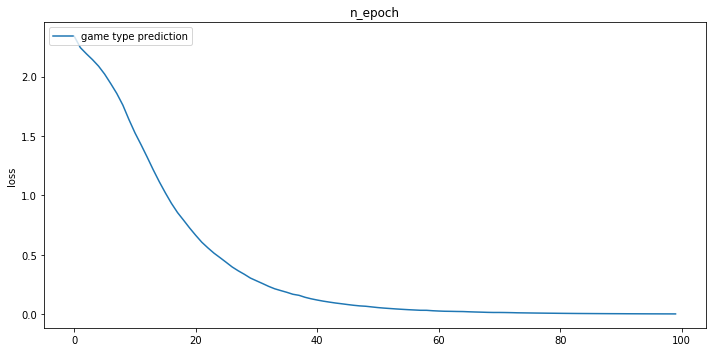

In [19]:
X, Y = range(len(avg_loss)), avg_loss

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, Y, label='game type prediction')
ax.set_title('n_epoch')
ax.legend(loc='upper left')
ax.set_ylabel('loss')
fig.tight_layout()
 
plt.show()

In [20]:
# torch.save(net, 'type_predictor3000.pth')

In [21]:
# net = torch.load('type_predictor3000.pth')

In [22]:
acc(train_set)

1.0

In [23]:
acc_by_class(train_set)

for pos_attac class acc = 1.0
for stand_attac class acc = 1.0
for build_up class acc = 1.0
for counter class acc = 1.0
for mid_press class acc = 1.0
for pos_defence class acc = 1.0
for high_press class acc = 1.0
for stand_defence class acc = 1.0
for corn_defence class acc = 1.0
for corn_defense class acc = 1.0
for clear class acc = 1.0
for pos_defense class acc = 1.0


In [24]:
acc(test_set)

0.1752136752136752

In [25]:
acc_by_class(test_set)

for high_press class acc = 0.0
for pos_attac class acc = 0.19230769230769232
for clear class acc = 0.0
for pos_defence class acc = 0.1346153846153846
for build_up class acc = 0.5576923076923077
for mid_press class acc = 0.3173076923076923
for stand_defence class acc = 0.0


In [26]:
n = 5
p = predict(net, train_set[n][0].view(26, 3, 133, 200))
p

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [27]:
ix2c[int(p[0])], train_set[n][1], c2ix[train_set[n][1]]

('build_up', 'build_up', 0)

In [28]:
binary_classes = {'pos_attac': 1,
                  'mid_press': 0,
                  'high_press': 0,
                  'corn_defence': 0,
                  'pos_defence': 0,
                  'build_up': 1,
                  'stand_defence': 0,
                  'counter': 1,
                  'corn_defense': 0,
                  'clear': 1,
                  'stand_attac': 1,
                  'pos_defense': 0}

bin_classes_counter = Counter()
for key in c.keys():
    bin_classes_counter[binary_classes[key]] += c[key]

bin_classes_counter.most_common()

[(1, 57), (0, 43)]

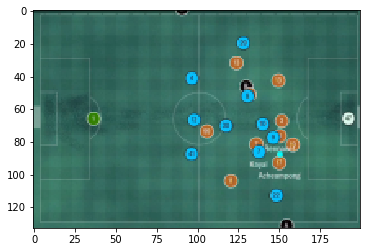

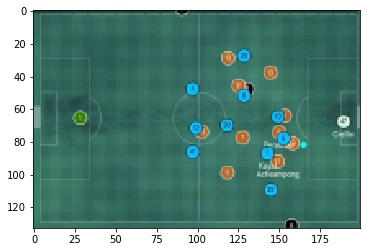

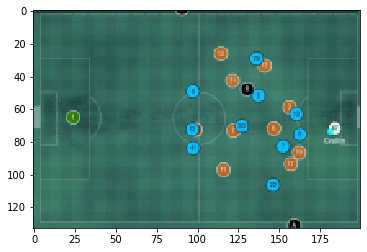

In [34]:
for image in train_set[5][0][::9]:
    plt.imshow(image.int())
    plt.show()